In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from matplotlib import rc

/work/shuhei-ky/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp_id = 'kitti_resdcnddu'
arch = 'resdcnddu_101'
exp_dir = f'/work/shuhei-ky/exp/CenterNet/models/gmm/{exp_id}'

In [3]:
"""
logits_kitti = torch.load(f"{exp_dir}/logits_dladdu_34_kitti.pt").cpu()
logits_weather_kitti = torch.load(f"{exp_dir}/logits_dladdu_34_weather_kitti.pt").cpu()
logits_bdd = torch.load(f"{exp_dir}/logits_dladdu_34_bdd.pt").cpu()
logits_coco = torch.load(f"{exp_dir}/logits_dladdu_34_coco.pt").cpu()
"""
densities_kitti = torch.load(f"{exp_dir}/densities_{arch}_kitti.pt").cpu()
densities_noise_kitti = torch.load(f"{exp_dir}/densities_{arch}_noise_kitti.pt").cpu()
densities_weather_kitti = torch.load(f"{exp_dir}/densities_{arch}_weather_kitti.pt").cpu()
densities_coco = torch.load(f"{exp_dir}/densities_{arch}_coco.pt").cpu()

entropies_kitti = torch.load(f"{exp_dir}/entropies_{arch}_kitti.pt").cpu()
entropies_noise_kitti = torch.load(f"{exp_dir}/entropies_{arch}_noise_kitti.pt").cpu()
entropies_weather_kitti = torch.load(f"{exp_dir}/entropies_{arch}_weather_kitti.pt").cpu()
entropies_coco = torch.load(f"{exp_dir}/entropies_{arch}_coco.pt").cpu()

In [4]:
epistemic_uncertainties_kitti = torch.load(f"{exp_dir}/epistemic_uncertainties_{arch}_kitti.pt").cpu()
aleatoric_uncertainties_kitti = torch.load(f"{exp_dir}/aleatoric_uncertainties_{arch}_kitti.pt").cpu()
epistemic_uncertainties_noise_kitti = torch.load(f"{exp_dir}/epistemic_uncertainties_{arch}_noise_kitti.pt").cpu()
aleatoric_uncertainties_noise_kitti = torch.load(f"{exp_dir}/aleatoric_uncertainties_{arch}_noise_kitti.pt").cpu()
epistemic_uncertainties_coco = torch.load(f"{exp_dir}/epistemic_uncertainties_{arch}_coco.pt").cpu()
aleatoric_uncertainties_coco = torch.load(f"{exp_dir}/aleatoric_uncertainties_{arch}_coco.pt").cpu()

In [5]:
clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']

sb.set_style('whitegrid')
sb.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

rc('text', usetex=False)

In [6]:
def plot_density(densities1, densities2, binrange, separate_ID=False):
    clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']
    sb.set_style('whitegrid')
    
    quantile_array = np.percentile(densities1, q=[80])
    print("quantile_array:", quantile_array)

    plt.figure(figsize=(2.5,2.5/1.6))
    plt.tight_layout()

    range = dict(bins=30, binrange=binrange, element="step", fill=True, alpha=0.5)
    kw_separate_id = dict(hue="category", multiple="stack",
                hue_order=[1, 0],
                palette=[sb.color_palette()[4], sb.color_palette()[0]]) if separate_ID else dict(color=sb.color_palette()[0])

    sb.histplot(densities1, **kw_separate_id,
                stat='probability', kde=False, **range, label="dummy", legend=False) # 'Dirty-MNIST (In-distribution)')
    sb.histplot(densities2, color=sb.color_palette()[1],
                stat='probability', kde=False, **range, label="dummy", legend=False) #, label='Fashion-MNIST (OoD)')


    plt.xlabel('Log Density', fontsize=12)
    plt.ylabel('Fraction', fontsize=12)
    
    vmin, vmax = plt.gca().get_ylim()
    """
    for each in quantile_array:
        plt.vlines(each, vmin, vmax, color='red', linestyles='dotted')
    """
    
    return quantile_array[0]


def plot_entropy(entropies1, entropies2, binrange, separate_ID=False):
    common_kwargs = dict(stat='probability', kde=False, bins=12, binrange=binrange, label="dummy", legend=False, element="step", alpha=0.5)
    id_kwargs = dict(
              hue="category", multiple="stack", 
              palette=[sb.color_palette()[0], sb.color_palette()[4]]) if separate_ID else dict(color=sb.color_palette()[0]) 
    
    quantile_array = np.percentile(entropies1, q=[12])
    print("quantile_array:", quantile_array)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(2.5,2.5/1.6), gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True)
    fig.subplots_adjust(hspace=0.30)  # adjust space between axes

    for ax in axes:
        sb.histplot(entropies1, **id_kwargs,
                    **common_kwargs, ax=ax)
        sb.histplot(entropies2, color=sb.color_palette()[1],
                    **common_kwargs, ax=ax)

    axes[0].set_ylim(0.4, 1.2)  # outliers only
    axes[1].set_ylim(0, .05)  # most of the data

    axes[0].spines['bottom'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[0].set_ylabel("")
    axes[1].set_ylabel("Fraction", fontsize=12)
    axes[1].set_xlabel("Entropy", fontsize=12)

    axes[1].yaxis.set_label_coords(-0.04, 0.5, fig.transFigure)

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axes[0].plot([0, 1], [0, 0], transform=axes[0].transAxes, **kwargs)
    axes[1].plot([0, 1], [1, 1], transform=axes[1].transAxes, **kwargs)
    """
    vmin, vmax = plt.gca().get_ylim()
    
    for each in quantile_array:
        plt.vlines(each, vmin, vmax, color='red', linestyles='dotted')
    """

    fig.set_size_inches(2.5,2.5/1.6)

    return quantile_array[0]


separate_ID = False

quantile_array: [-227.27796631]


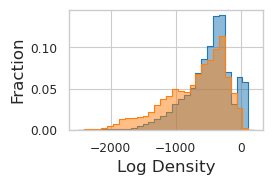

In [16]:
density_threshold = plot_density(densities_kitti, densities_coco, binrange=[-2500, 200], separate_ID=separate_ID)
plt.savefig(f'{exp_dir}/densities_hist_kitti_vs_coco.png', bbox_inches='tight')

quantile_array: [-227.27796631]


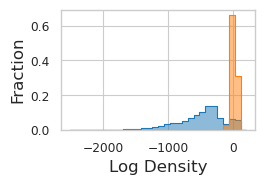

In [17]:
density_threshold = plot_density(densities_kitti, densities_noise_kitti, binrange=[-2500, 200], separate_ID=separate_ID)
plt.savefig(f'{exp_dir}/densities_hist_kitti_vs_noise_kitti.png', bbox_inches='tight')

quantile_array: [-227.27796631]


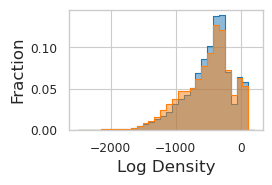

In [18]:
density_threshold = plot_density(densities_kitti, densities_weather_kitti, binrange=[-2500, 200], separate_ID=separate_ID)
plt.savefig(f'{exp_dir}/densities_hist_kitti_vs_weather_kitti.png', bbox_inches='tight')

quantile_array: [1.09214711]


/tmp/ipykernel_1460522/318396484.py:44: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0.30)  # adjust space between axes


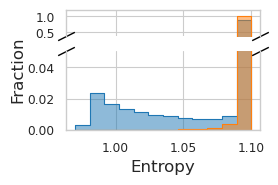

In [19]:
entropy_threshold = plot_entropy(entropies_kitti, entropies_coco, binrange=[0.97, 1.1], separate_ID=separate_ID)
plt.savefig(f'{exp_dir}/entropies_hist_kitti_vs_coco.png', bbox_inches='tight')

quantile_array: [1.09214711]


/tmp/ipykernel_1460522/318396484.py:44: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0.30)  # adjust space between axes


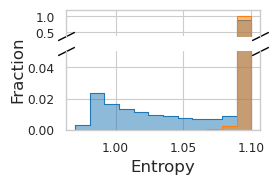

In [20]:
entropy_threshold = plot_entropy(entropies_kitti, entropies_noise_kitti, binrange=[0.97, 1.1], separate_ID=separate_ID)
plt.savefig(f'{exp_dir}/entropies_hist_kitti_vs_noise_kitti.png', bbox_inches='tight')

quantile_array: [1.09214711]


/tmp/ipykernel_1460522/318396484.py:44: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0.30)  # adjust space between axes


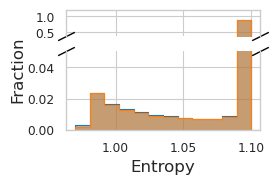

In [21]:
entropy_threshold = plot_entropy(entropies_kitti, entropies_weather_kitti, binrange=[0.97, 1.1], separate_ID=separate_ID)
plt.savefig(f'{exp_dir}/entropies_hist_kitti_vs_weather_kitti.png', bbox_inches='tight')

In [132]:
torch.save(density_threshold, f"{exp_dir}/density_threshold_{arch}.pt")
torch.save(entropy_threshold, f"{exp_dir}/entropy_threshold_{arch}.pt")